In [ ]:
!pip install findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 199 kB 53.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=2534e37551865b930e307abced79079b12cfb7861ca9e3028b5837f1631622bd
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark import ml
from pyspark import mllib
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

In [ ]:
def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

spark, sc = init_spark('demo')
sc

<SparkContext master=local[*] appName=demo>

In [ ]:
dataPath_hw = "/content/drive/MyDrive/data.json"

data_df = spark.read.format("json")\
  .option("header","true")\
  .option("escape", "\"")\
  .option("inferSchema", "true")\
  .load(dataPath_hw)

Model Creation

Pipeline(With NULL label):

In [ ]:
transformer_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=["Model", "Device",'gt', 'User'],\
                  outputCols=["Model_idx", "Device_idx", "gt_idx", 'User_idx']),
    OneHotEncoder(inputCol="Device_idx", outputCol="Device_vec"),
    OneHotEncoder(inputCol="User_idx", outputCol="User_vec"),
    VectorAssembler(inputCols=["Device_vec","Arrival_Time", "Creation_Time", "Index", 'User_vec','x','y','z'], outputCol="features")
])
model = transformer_pipeline.fit(data_df)
train_set, test_set = model.transform(data_df).randomSplit([0.7,0.3], seed = 33)

Pipeline (No NULL label):

In [ ]:
data_df_nn = data_df.select('*').where(f.col('gt')!='null')

transformer_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=["Model", "Device",'gt', 'User'],\
                  outputCols=["Model_idx", "Device_idx", "gt_idx", 'User_idx']),
    OneHotEncoder(inputCol="Device_idx", outputCol="Device_vec"),
    OneHotEncoder(inputCol="User_idx", outputCol="User_vec"),
    VectorAssembler(inputCols=["Device_vec", "Index", 'User_vec','x','y','z'], outputCol="features")
])
model = transformer_pipeline.fit(data_df_nn)
train_set, test_set = model.transform(data_df_nn).randomSplit([0.7,0.3], seed = 33)

Train model:

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
m = 30
dt = DecisionTreeClassifier(labelCol="gt_idx",featuresCol="features", maxDepth=m)
fittedDT = dt.fit(train_set)

evaluate:

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator=MulticlassClassificationEvaluator(labelCol='gt_idx',predictionCol="prediction")
pred_dt_test = fittedDT.transform(test_set)
print(f'Decision Tree Accuracy Testset: {evaluator.evaluate(pred_dt_test)}')

Decision Tree Accuracy Testset: 0.9442948737770059


No NULL label:

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


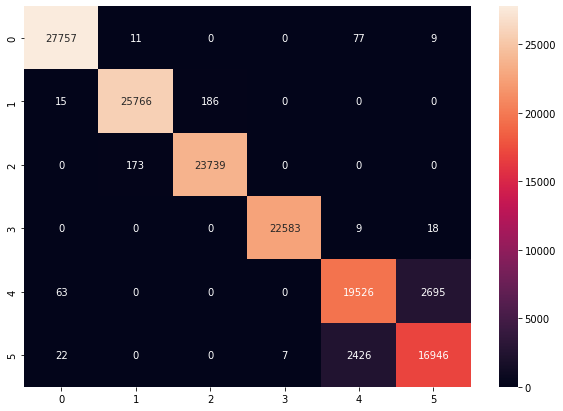

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyspark.mllib.evaluation import MulticlassMetrics

pred_list = pred_dt_test.select('gt_idx', 'prediction')
metrics = MulticlassMetrics(pred_list.rdd.map(tuple))
df_cm = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in range(6)],
                  columns = [i for i in range(6)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.7g')

In [ ]:
test_set.select('gt','gt_idx').distinct().show()

+----------+------+
|        gt|gt_idx|
+----------+------+
|      walk|   0.0|
|       sit|   1.0|
|stairsdown|   5.0|
|      bike|   3.0|
|  stairsup|   4.0|
|     stand|   2.0|
+----------+------+



With NULL label:

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


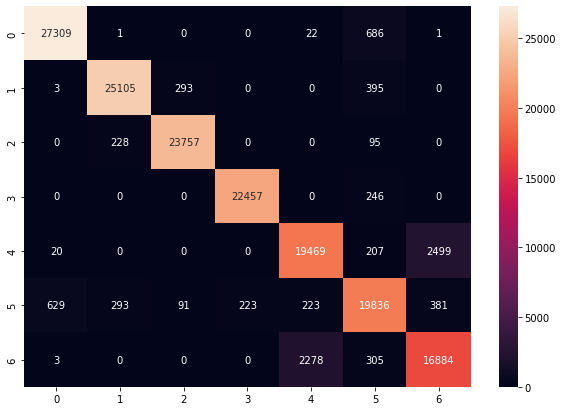

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyspark.mllib.evaluation import MulticlassMetrics

pred_list = pred_dt_test.select('gt_idx', 'prediction')
metrics = MulticlassMetrics(pred_list.rdd.map(tuple))
df_cm_2 = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_2, annot=True, fmt='.7g')

In [ ]:
test_set.select('gt','gt_idx').distinct().show()

+----------+------+
|        gt|gt_idx|
+----------+------+
|      walk|   0.0|
|       sit|   1.0|
|      null|   5.0|
|      bike|   3.0|
|stairsdown|   6.0|
|  stairsup|   4.0|
|     stand|   2.0|
+----------+------+



In [ ]:
dataPath_full = "/content/drive/MyDrive/Phones_accelerometer.csv"

data_full = spark.read.format("csv")\
  .option("header","true")\
  .option("escape", "\"")\
  .option("inferSchema", "true")\
  .load(dataPath_full)

In [ ]:
transformer_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=["Model", "Device",'gt', 'User'],\
                  outputCols=["Model_idx", "Device_idx", "gt_idx", 'User_idx']),
    OneHotEncoder(inputCol="Device_idx", outputCol="Device_vec"),
    OneHotEncoder(inputCol="User_idx", outputCol="User_vec"),
    VectorAssembler(inputCols=["Device_vec","Arrival_Time", "Creation_Time", "Index", 'User_vec','x','y','z'], outputCol="features")
])
model = transformer_pipeline.fit(data_full)
train_set_f, test_set_f = model.transform(data_full).randomSplit([0.1,0.9], seed = 33)


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
m = 30
dt = DecisionTreeClassifier(labelCol="gt_idx",featuresCol="features", maxDepth=m)
fittedDT = dt.fit(train_set_f)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator=MulticlassClassificationEvaluator(labelCol='gt_idx',predictionCol="prediction")
pred_dt_test = fittedDT.transform(test_set_f)
print(f'Decision Tree Accuracy Testset: {evaluator.evaluate(pred_dt_test)}')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyspark.mllib.evaluation import MulticlassMetrics

pred_list = pred_dt_test.select('gt_idx', 'prediction')
metrics = MulticlassMetrics(pred_list.rdd.map(tuple))
df_cm_2 = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_2, annot=True, fmt='.7g')

In [ ]:
transformer_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=["Model", "Device",'gt', 'User'],\
                  outputCols=["Model_idx", "Device_idx", "gt_idx", 'User_idx']),
    OneHotEncoder(inputCol="Device_idx", outputCol="Device_vec"),
    OneHotEncoder(inputCol="User_idx", outputCol="User_vec"),
    VectorAssembler(inputCols=["Device_vec","Arrival_Time", "Creation_Time", "Index", 'User_vec','x','y','z'], outputCol="features")
])
model = transformer_pipeline.fit(data_full)
train_set_f, test_set_f = model.transform(data_full).randomSplit([0.1,0.9], seed = 33)
